In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

In [2]:
x = pd.read_csv('EWA.csv',index_col=0)['Close']
y = pd.read_csv('EWC.csv',index_col=0)['Close']

In [3]:
df = pd.concat([x,y], axis=1)
df.columns = ["EWA", "EWC"]
df.index = pd.to_datetime(df.index)

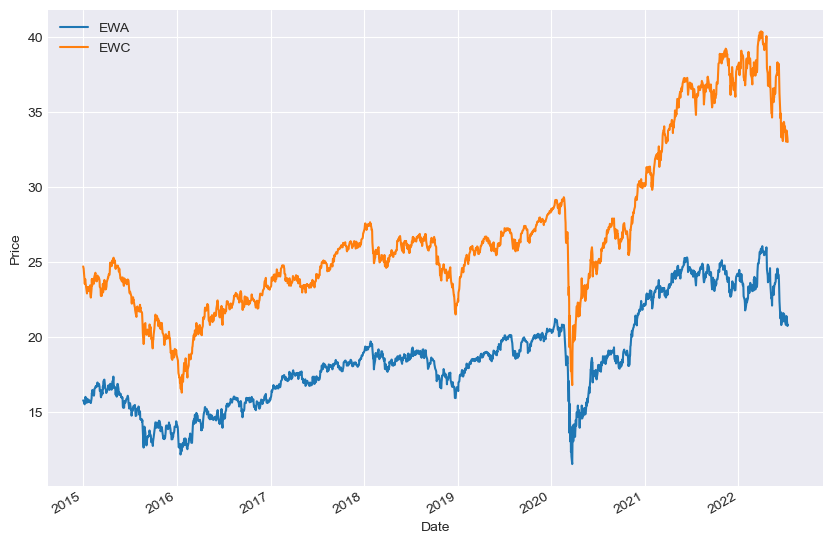

In [4]:
df.plot(figsize=(10,7))
plt.ylabel("Price")
plt.show()

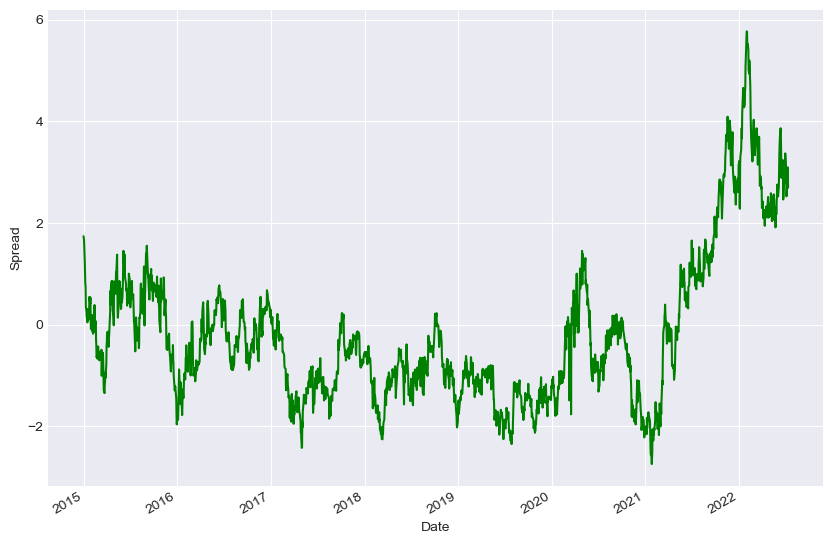

In [5]:
from statsmodels.api import OLS
model = OLS(df.EWC.iloc[:90], df.EWA.iloc[:90])
model = model.fit()
df['spread'] = df.EWC - model.params[0] * df.EWA

# Plot the spread
df.spread.plot(figsize=(10,7), color='g')
plt.ylabel("Spread")
plt.show()

## Mean Reversion Strategy Function

In [6]:
def mean_reversion_strategy(df, lookback, std_dev):
    # Moving Average
    df['Moving_Average'] = df.spread.rolling(lookback).mean()
    # Moving Standard Deviation
    df['Moving_Std'] = df.spread.rolling(lookback).std()
    
    #Upper Band and Lower Band
    df['Upper_Band'] = df['Moving_Average'] + std_dev * df['Moving_Std']
    df['Lower_Band'] = df['Moving_Average'] - std_dev * df['Moving_Std']
    
    # Long Positions
    df['Long_Entry'] = df['spread'] < df['Lower_Band']
    df['Long_Exit'] = df['spread'] >= df['Moving_Average']
    
    df['Long_Positions'] = np.nan
    df.loc[df.Long_Entry, "Long_Positions"] = 1
    df.loc[df.Long_Exit, "Long_Positions"] = 0
    df.Long_Positions = df.Long_Positions.fillna(method='ffill')
    
    # Short Positions
    df['Short_Entry'] = df['spread'] > df['Lower_Band']
    df['Short_Exit'] = df['spread'] <= df['Moving_Average']
    
    df['Short_Positions'] = np.nan
    df.loc[df.Short_Entry,"Short_Positions"] = -1
    df.loc[df.Short_Exit, "Short_Positions"] = 0
    df.Short_Positions = df.Short_Positions.fillna(method='ffill')
    
    # Positions
    df['Positions'] = df.Long_Positions + df.Short_Positions
    
    return df

In [7]:
df = mean_reversion_strategy(df,90,2)

## Cumulative Returns

In [8]:
df['Percentage_Change'] = (df.spread- df.spread.shift(1))/(model.params[0]*df.EWA + df.EWC)
df['Strategy_Returns'] = df.Positions.shift(1) * df.Percentage_Change
df['Cumulative_Returns'] = (df.Strategy_Returns+1).cumprod()
"The total strategy returns are %.2f" % ((df['Cumulative_Returns'].iloc[-1]-1)*100)

'The total strategy returns are 51.99'

In [9]:
s = np.mean(df['Strategy_Returns'])/np.std(df['Strategy_Returns'])*np.sqrt(252)
'The Sharpe Ratio %.2f' % s

'The Sharpe Ratio 1.00'

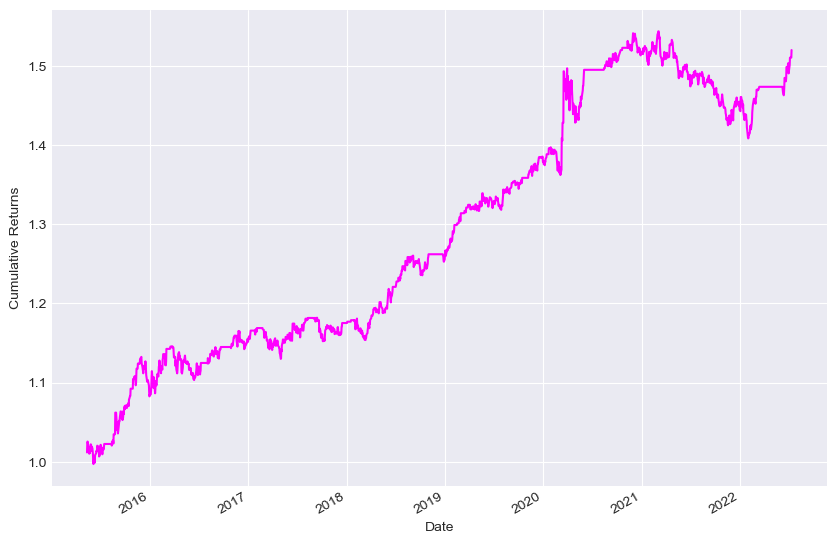

In [10]:
df.Cumulative_Returns.plot(label='Returns', figsize=(10,7),color='magenta')  
plt.xlabel('Date')  
plt.ylabel('Cumulative Returns')  
plt.show()

The maximum drawdown is -8.76


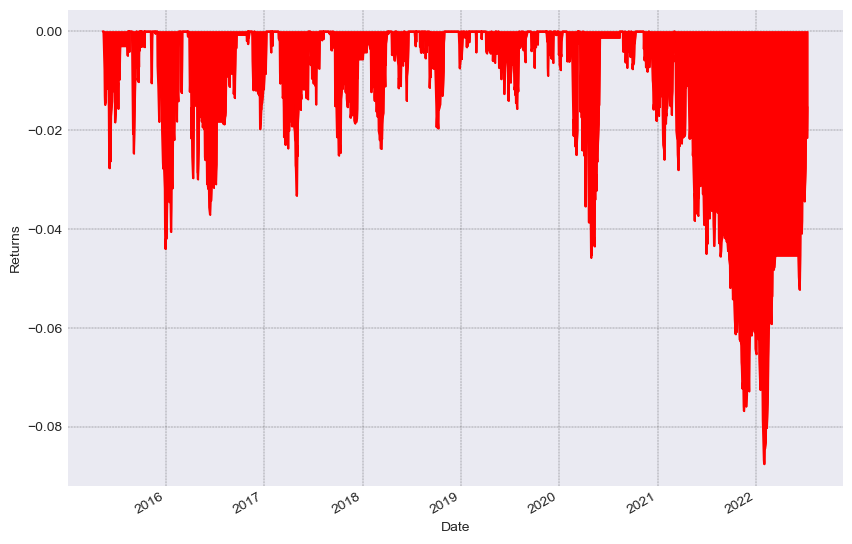

In [11]:
def calc_drawdown(cum_rets):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (cum_rets)/running_max - 1
    return drawdown

def plot_drawdown(drawdown):
    fig = plt.figure(figsize=(10, 7))
    # Plot
    drawdown.plot(color='r')
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()
    
drawdown = calc_drawdown(df.Cumulative_Returns)
print("The maximum drawdown is %.2f" % (drawdown.min()*100))
plot_drawdown(drawdown)